In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# create a base class for an automap schema
Base = automap_base()


In [12]:
# reflect the tables using the base class
Base.prepare(autoload_with=engine)

In [13]:
# print the mapped classes
print(Base.classes.keys())

['measurement', 'station']


In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)


View of the Measurement Table

In [16]:
# print the header of the measurement table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x164a8e5c0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1}

In [17]:
# print the data types of the measurement table
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


View of the Station Table

In [18]:
# print the header of the station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x164a8f4c0>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

In [19]:
# print the data types of the station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [20]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)
print(type(most_recent_date))


('2017-08-23',)
<class 'sqlalchemy.engine.row.Row'>


In [21]:
# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)
print(type(one_year_ago))

2016-08-23
<class 'datetime.date'>


In [22]:

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [24]:
# precipitation_df sorted by date
precipitation_df = precipitation_df.sort_values('date')
precipitation_df = precipitation_df.set_index('date')
precipitation_df.head()


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


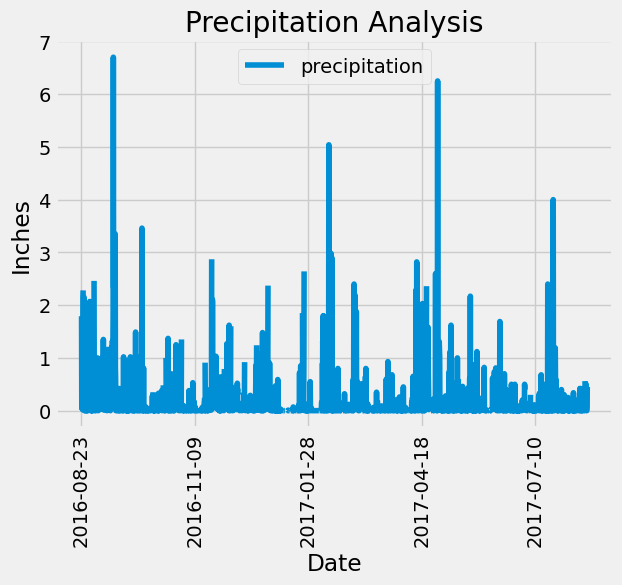

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Analysis')
plt.show()

In [26]:
# summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [28]:
# total unique stations in the measurement table
total_stations_Station = session.query(Station.station).distinct().count()
total_stations_Station

9

In [29]:
# total unique stations in the measurement table
total_stations_Measurement = session.query(Measurement.station).distinct().count()
total_stations_Measurement

9

In [30]:
# station activity in the measurement table
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# station with the highest number of observations
most_active_station = station_activity[0][0]
most_active_station

'USC00519281'

In [32]:
# min, max, and avg temperature for USC00519281
temperature_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temperature_data

[(54.0, 85.0, 71.66378066378067)]

In [33]:
# the most recent date for USC00519281
most_recent_date = session.query(Measurement.date).filter(Measurement.station == most_active_station).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-18',)

In [34]:
# the last 12 months of temperature observation data for USC00519281
one_year_ago_USC00519281 = dt.date(2017, 8, 18) - dt.timedelta(days=365)
print(one_year_ago_USC00519281)

2016-08-18


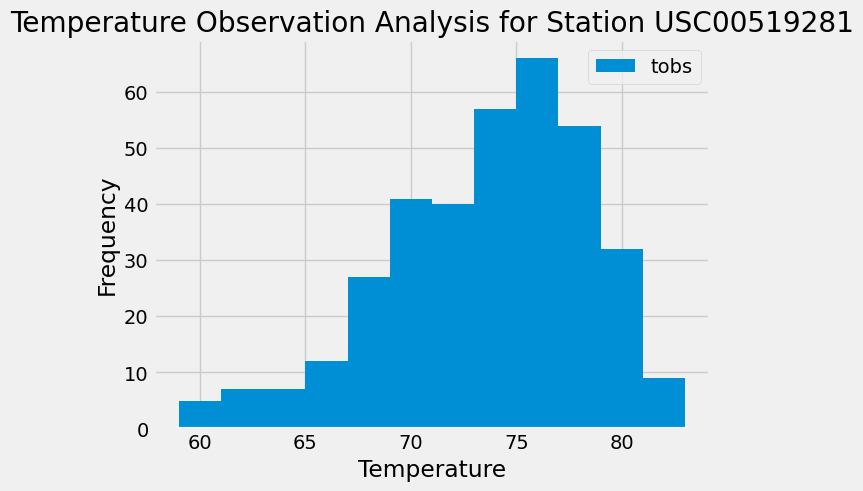

In [35]:
# histogram of the temperature observation data for USC00519281 between 8/18/2016 and 8/18/2017
temperature_data_USC00519281 = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago_USC00519281).all()
temperature_data_USC00519281_df = pd.DataFrame(temperature_data_USC00519281, columns=['tobs'])
temperature_data_USC00519281_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation Analysis for Station USC00519281')
plt.show()

# Close Session

In [36]:
# Close Session
session.close()